In [1]:
import pandas as pd
from plotnine import *

df = pd.read_csv('resnet_results.csv')
df

,Name,n_params,val_acc,corrupt_frac,_wandb
0,jumping-violet-51,857898,0.5577,0.5,NaN
1,distinctive-energy-50,663018,0.5747,0.5,NaN
2,wandering-jazz-49,468138,0.6112,0.5,NaN
3,dry-elevator-48,273258,0.6394,0.5,NaN
4,fast-firebrand-47,857898,0.6472,0.4,NaN
5,volcanic-yogurt-46,663018,0.6481,0.4,NaN
6,smart-bush-45,857898,0.7395,0.3,NaN
7,true-waterfall-44,468138,0.6774,0.4,NaN
8,effortless-galaxy-43,273258,0.7126,0.4,NaN
9,wise-glade-41,663018,0.7360,0.3,NaN


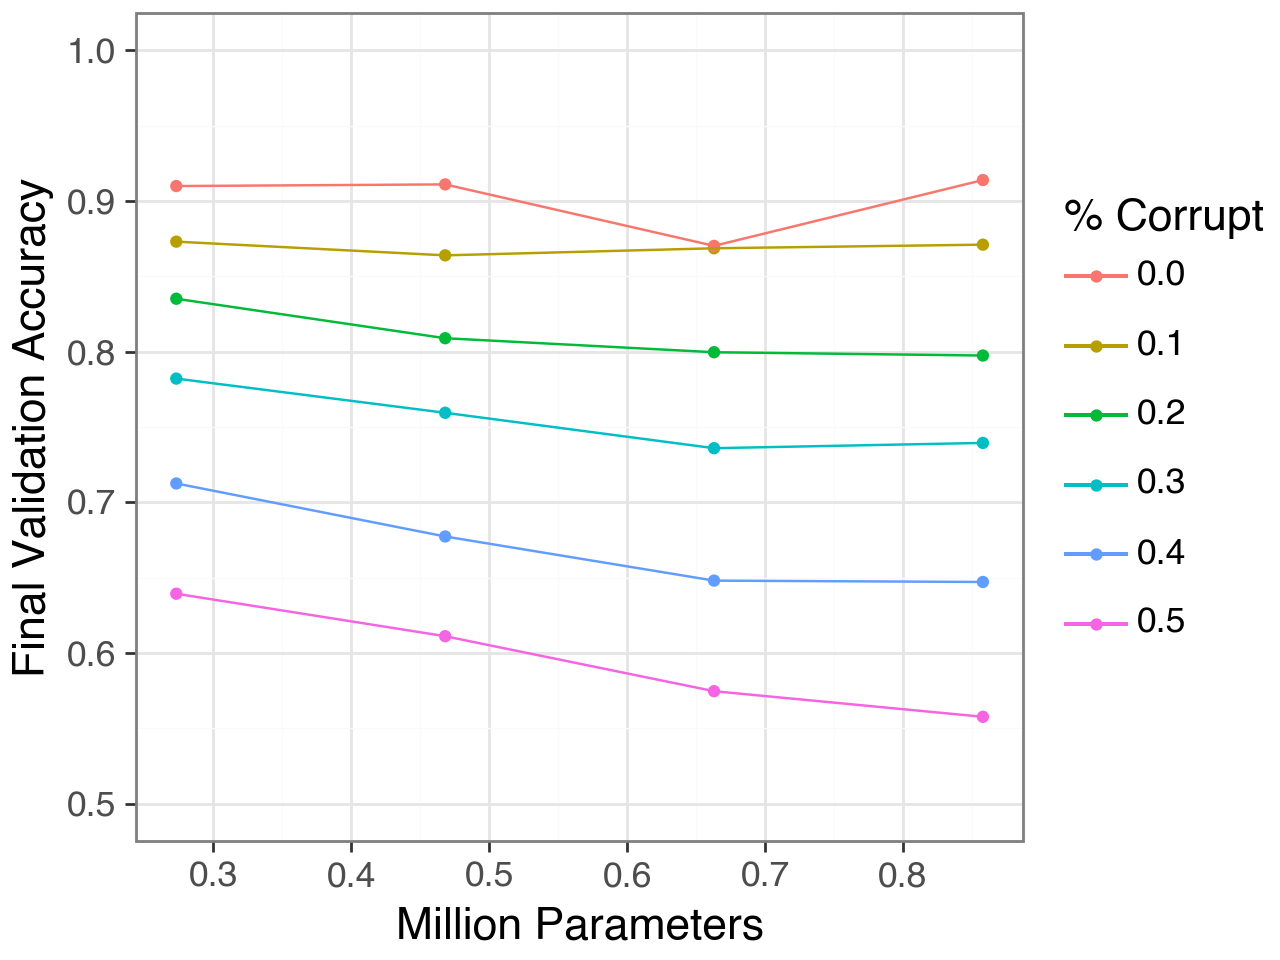

In [2]:
(
    df
    .assign(corrupt_frac =  df.corrupt_frac.astype('category'), n_params = df.n_params / 1e6)
    .pipe(ggplot, aes(x='n_params', y='val_acc', color='corrupt_frac', group = 'corrupt_frac')) +
    geom_point() +
    geom_line() +
    ylim(0.5, 1) +
    labs(x = "Million Parameters", y = "Final Validation Accuracy", color = "% Corrupt") +
    theme_bw(base_size=16)
)